<a href="https://colab.research.google.com/github/gabrielsantanafibralink-dot/projeto-analise-teste-ab/blob/main/Projeto_De_Analise_Teste_AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Teste A/B de Campanha de Marketing

**Autor:** Gabriel Santan


## 1. Introdução e Contexto do Problema

Este projeto analisa os resultados de um teste A/B conduzido por uma empresa de marketing digital. O objetivo é avaliar a eficácia de uma nova campanha de propaganda (`psa` - public service announcement) em comparação com a campanha antiga (`ad`).

A principal métrica de sucesso é a **taxa de conversão**, que representa a porcentagem de usuários que realizaram uma compra após visualizarem a propaganda.

O objetivo final é fornecer uma recomendação de negócio, baseada em evidências estatísticas, sobre qual das duas campanhas deve ser utilizada pela empresa.

In [1]:
# Configuração do ambiente: importando as bibliotecas necessárias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Carregamento e Preparação dos Dados

Os dados foram obtidos de um dataset público no Kaggle e estão hospedados em um repositório no GitHub para garantir a total reprodutibilidade desta análise.

Nesta etapa, vamos:
1.  Carregar os dados a partir da URL.
2.  Inspecionar a estrutura inicial do dataset.
3.  Realizar a limpeza, removendo colunas desnecessárias e renomeando as demais para maior clareza.

In [2]:
# Carregar os dados a partir do link "raw" do GitHub
url = 'https://raw.githubusercontent.com/gabrielsantanafibralink-dot/projeto-analise-teste-ab/main/data/marketing_AB.csv'
df = pd.read_csv(url)

# Renomear a coluna de índice que veio do CSV e as demais colunas
df.rename(columns={'Unnamed: 0': 'indice'}, inplace=True)
df.columns = ['indice', 'id_usuario', 'grupo_teste', 'convertido', 'total_anuncios', 'dia_mais_anuncios', 'hora_mais_anuncios']


# Verificar a integridade dos dados
print("--- Informações Gerais do DataFrame ---")
df.info()

print("\n--- Verificação de Valores Nulos ---")
print(df.isnull().sum())

print("\n--- Verificação de Duplicatas de Usuário ---")
print(f"Total de linhas: {len(df)}")
print(f"Total de usuários únicos: {df['id_usuario'].nunique()}")

--- Informações Gerais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   indice              588101 non-null  int64 
 1   id_usuario          588101 non-null  int64 
 2   grupo_teste         588101 non-null  object
 3   convertido          588101 non-null  bool  
 4   total_anuncios      588101 non-null  int64 
 5   dia_mais_anuncios   588101 non-null  object
 6   hora_mais_anuncios  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB

--- Verificação de Valores Nulos ---
indice                0
id_usuario            0
grupo_teste           0
convertido            0
total_anuncios        0
dia_mais_anuncios     0
hora_mais_anuncios    0
dtype: int64

--- Verificação de Duplicatas de Usuário ---
Total de linhas: 588101
Total de usuários únicos: 588101


## 3. Análise Visual da Taxa de Conversão

Com os dados limpos e preparados, o próximo passo é realizar uma análise exploratória visual. O objetivo é calcular e visualizar a taxa de conversão para cada um dos grupos (`ad` e `psa`) para identificar se existe uma diferença aparente entre eles.

--- Taxa de Conversão por Grupo ---
    grupo_descritivo  taxa_conversao_pct
0  Propaganda Antiga            2.554656
1    Propaganda Nova            1.785411




/tmp/ipython-input-558600913.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='grupo_descritivo', y='taxa_conversao_pct', data=taxa_conversao, palette='viridis')


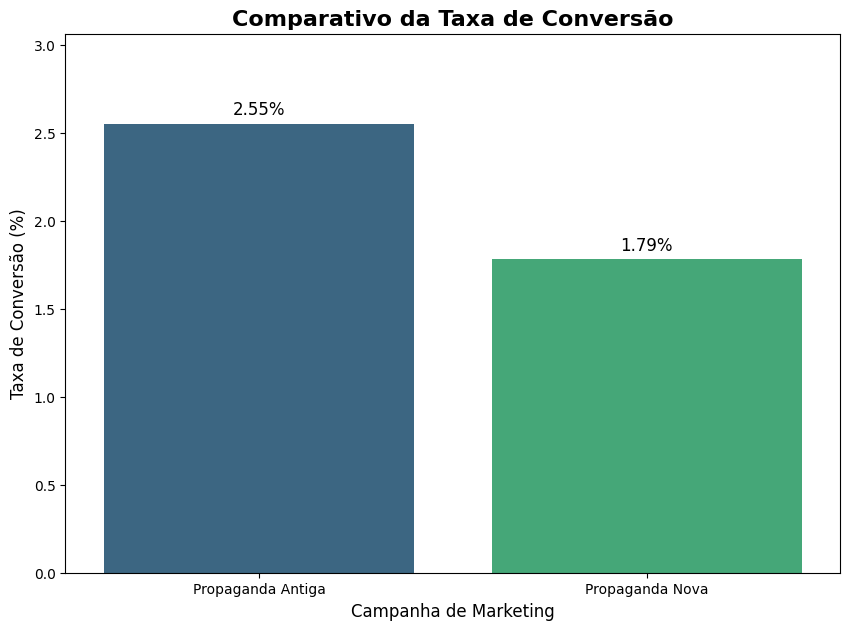

In [3]:
# Calcular a taxa de conversão para cada grupo
taxa_conversao = df.groupby('grupo_teste')['convertido'].mean().reset_index()
taxa_conversao['taxa_conversao_pct'] = taxa_conversao['convertido'] * 100

# Criar uma coluna com nomes descritivos para o gráfico
mapa_nomes = {'ad': 'Propaganda Antiga', 'psa': 'Propaganda Nova'}
taxa_conversao['grupo_descritivo'] = taxa_conversao['grupo_teste'].map(mapa_nomes)

print("--- Taxa de Conversão por Grupo ---")
print(taxa_conversao[['grupo_descritivo', 'taxa_conversao_pct']])
print("\n")

# Criar o gráfico de barras para visualizar a diferença
plt.figure(figsize=(10, 7))
barplot = sns.barplot(x='grupo_descritivo', y='taxa_conversao_pct', data=taxa_conversao, palette='viridis')

# Adicionar títulos e rótulos
plt.title('Comparativo da Taxa de Conversão', fontsize=16, fontweight='bold')
plt.xlabel('Campanha de Marketing', fontsize=12)
plt.ylabel('Taxa de Conversão (%)', fontsize=12)
plt.ylim(0, max(taxa_conversao['taxa_conversao_pct']) * 1.2)

# Adicionar os rótulos de dados em cima de cada barra
for index, row in taxa_conversao.iterrows():
    barplot.text(x=index,
                 y=row.taxa_conversao_pct + 0.05,
                 s=f"{row.taxa_conversao_pct:.2f}%",
                 color='black',
                 ha="center",
                 fontsize=12)

plt.show()

## 4. Teste de Hipóteses Estatísticas

A análise visual sugere que a "Propaganda Antiga" possui uma taxa de conversão superior. No entanto, para confirmar se essa diferença é estatisticamente significativa e não apenas fruto do acaso, realizaremos um **Teste Qui-Quadrado de Independência**.

Este teste é apropriado para comparar proporções entre duas ou mais categorias.

- **$H_0$ (Hipótese Nula):** Não há diferença estatisticamente significativa na taxa de conversão entre os dois grupos.
- **$H_1$ (Hipótese Alternativa):** Existe uma diferença estatisticamente significativa na taxa de conversão entre os dois grupos.

Adotaremos um **nível de significância (alpha) de 5% (ou 0.05)**. Se o p-valor resultante do teste for menor que 0.05, rejeitaremos a Hipótese Nula.

In [4]:
# Criar uma tabela de contingência para o teste
tabela_contingencia = pd.crosstab(df['grupo_teste'], df['convertido'])

print("--- Tabela de Contingência ---")
print(tabela_contingencia)
print("\n")

# Realizar o teste Qui-Quadrado
chi2, p_valor, dof, expected = chi2_contingency(tabela_contingencia)

print("--- Resultados do Teste Estatístico ---")
print(f"Estatística Qui-Quadrado: {chi2:.4f}")
print(f"P-valor: {p_valor:.4f}")
print("\n")

# Interpretar o resultado
alpha = 0.05
if p_valor < alpha:
    print(f"Conclusão: P-valor ({p_valor:.4f}) é menor que alpha (0.05). Rejeitamos a Hipótese Nula.")
else:
    print(f"Conclusão: P-valor ({p_valor:.4f}) é maior que alpha (0.05). Não podemos rejeitar a Hipótese Nula.")

--- Tabela de Contingência ---
convertido    False  True 
grupo_teste               
ad           550154  14423
psa           23104    420


--- Resultados do Teste Estatístico ---
Estatística Qui-Quadrado: 54.0058
P-valor: 0.0000


Conclusão: P-valor (0.0000) é menor que alpha (0.05). Rejeitamos a Hipótese Nula.


## 5. Conclusão Final e Recomendação

O Teste Qui-Quadrado resultou em um **p-valor significativamente menor que 0.05**, o que nos leva a **rejeitar a Hipótese Nula**. Isso confirma que a diferença observada nas taxas de conversão entre as duas campanhas é **estatisticamente significativa**.

A "Propaganda Antiga" apresentou uma taxa de conversão de **2.55%**, enquanto a "Propaganda Nova" teve uma taxa de **1.79%**.

### Recomendação de Negócio

Com base na análise de dados, a recomendação para a empresa é **não prosseguir com o lançamento da nova propaganda (PSA)**. A campanha antiga (`ad`) demonstrou ter uma performance estatisticamente superior na conversão de usuários. A implementação da nova campanha provavelmente resultaria em uma queda na taxa de conversão geral.